### 1. Достаём данные

Подгрузим таблицу из базы данных.

In [50]:
from pathlib import Path

import numpy as np

from price_prediction.fetch_data import get_csv_from_market_state

# get_csv_from_market_state(Path('data/data.csv'))

Прочитаем таблицу и сделаем базовый препроцессинг.

In [51]:
import pandas as pd

data = pd.read_csv('data/data.csv')
data.sample(10)

,id,item_id,name,price,engine,mileage,body_type,fuel_type,transmission,seller_type,...,gear_box,steering_wheel_side,documents_ok,owners_counter,car_is_wanted,car_is_busted,brand_name,model_name,year,is_bitten
29878,372403,2452567784,"Mercedes-Benz GLC-класс, 2019",2700000,2.0 AT,47000,внедорожник,бензин,полный,Автодилер,...,Ошибка,Ошибка,Ошибка,Ошибка,Ошибка,Ошибка,Mercedes-Benz,GLC-класс,2019,False
32451,1028299,3009076030,"Kia Rio, 2010",410000,1.4 AT,50000,седан,бензин,передний,Автодилер,...,Ошибка,Ошибка,Ошибка,Ошибка,Ошибка,Ошибка,Kia,Rio,2010,False
27578,372602,2895336196,"Mercedes-Benz GLC-класс Coupe, 2018",4250000,2.1 AT,77900,внедорожник,дизель,полный,Ошибка,...,Ошибка,Ошибка,Ошибка,Ошибка,Ошибка,Ошибка,Mercedes-Benz,GLC-класс Coupe,2018,False
14970,13983,2903024612,"Maybach 62, 2004",6025500,5.5 AT,66778,седан,бензин,задний,Автодилер,...,Ошибка,Ошибка,Ошибка,Ошибка,Ошибка,Ошибка,Maybach,62,2004,False
20189,502142,3074142007,"Hyundai Santa Fe, 2018",3250000,2.0 AT,53500,внедорожник,дизель,полный,Автодилер,...,Ошибка,Ошибка,Ошибка,Ошибка,Ошибка,Ошибка,Hyundai,Santa Fe,2018,False
17501,421300,3022348354,"Kia K5, 2022",2500000,2.0 AT,22424,седан,бензин,передний,Ошибка,...,Ошибка,Ошибка,Ошибка,Ошибка,Ошибка,Ошибка,Kia,K5,2022,False
46512,908276,2907868275,"Smart Fortwo, 2011",540000,1.0 AMT,206000,хетчбэк,бензин,задний,Автодилер,...,Ошибка,Ошибка,Ошибка,Ошибка,Ошибка,Ошибка,Smart,Fortwo,2011,False
47440,427942,3122729546,"Toyota RAV4, 2020",3080000,2.0 CVT,58060,внедорожник,бензин,полный,Ошибка,...,Ошибка,Ошибка,Ошибка,Ошибка,Ошибка,Ошибка,Toyota,RAV4,2020,False
33074,855843,3074360330,"Land Rover Range Rover Sport, 2022",18982150,3.0 AT,0,внедорожник,дизель,полный,Ошибка,...,Ошибка,Ошибка,Ошибка,Ошибка,Ошибка,Ошибка,Land Rover,Range Rover Sport,2022,False
21535,1093090,2944684705,"Mitsubishi Pajero Sport, 2022",5355180,2.4 AT,0,внедорожник,дизель,полный,Автодилер,...,Ошибка,Ошибка,Ошибка,Ошибка,Ошибка,Ошибка,Mitsubishi,Pajero Sport,2022,False


In [52]:
bad_cols = [col for col in data.columns if (data[col] == 'Ошибка').sum() > len(data) / 2]
data.drop(columns=bad_cols, inplace=True)

In [53]:
data.isna().sum()

id                     0
item_id                0
name                   0
price                  0
engine                 0
mileage                0
body_type              0
fuel_type              0
transmission           0
seller_type            0
city                   0
description            0
link                   0
market_type            0
predicted_price    50878
horse_power            0
brand_name            27
model_name            18
year                   0
is_bitten              0
dtype: int64

In [54]:
data.model_name = data.model_name.fillna('Ошибка')
data.brand_name = data.brand_name.fillna('Ошибка')

In [55]:
data.is_bitten = data.is_bitten.astype(int)

### 2. Делаем самые простые модели

Попробуем базовые реализации следующих моделей:
- Ridge-регрессия
- Decision Tree

Дополнительно попробуем учитывать текстовые описания. В качестве базового способа будем использовать tf-idf.

In [56]:
def preprocess(text):
    text = ''.join(list(filter(lambda x: str.isalnum(x) or x == ' ', text.lower())))
    words = filter(len, text.split(' '))
    return ' '.join(words)


data['text'] = data.description.apply(preprocess)

In [57]:
from sklearn.model_selection import train_test_split

data_train, data_test, y_train, y_test = train_test_split(data, data.price, test_size=0.2, random_state=42)

In [27]:
import typing as tp

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline


def fit_and_evaluate(model, transformer) -> tp.Dict[str, float]:
    pipeline = Pipeline([
        ('transformer', transformer),
        ('model', model)
    ])
    pipeline.fit(data_train, y_train)
    y_pred_train = pipeline.predict(data_train)
    y_pred_test = pipeline.predict(data_test)
    return {
        'Train MSE': mean_squared_error(y_train, y_pred_train),
        'Test MSE': mean_squared_error(y_test, y_pred_test),
        'Train MAPE': mean_absolute_percentage_error(y_train, y_pred_train),
        'Test MAPE': mean_absolute_percentage_error(y_test, y_pred_test)
    }

In [28]:
metrics = [
    'Train MSE',
    'Test MSE',
    'Train MAPE',
    'Test MAPE'
]
cmp_table = pd.DataFrame(columns=metrics)

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

categorical = ['engine', 'body_type', 'fuel_type', 'transmission', 'seller_type', 'brand_name', 'model_name']
numeric = ['mileage', 'horse_power', 'year']
passthrough = ['is_bitten']

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric),
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('passthrough', 'passthrough', passthrough)
])

column_transformer_with_tf_idf = ColumnTransformer([
    ('scaling', StandardScaler(), numeric),
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('tf-idf', TfidfVectorizer(), 'text'),
    ('passthrough', 'passthrough', passthrough)
])

In [34]:
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

cmp_table.loc['Ridge'] = fit_and_evaluate(Ridge(), column_transformer)
cmp_table.loc['Ridge + tf-idf'] = fit_and_evaluate(Ridge(), column_transformer_with_tf_idf)
cmp_table.loc['DecisionTree'] = fit_and_evaluate(DecisionTreeRegressor(), column_transformer)
cmp_table.loc['DecisionTree + tf-idf'] = fit_and_evaluate(DecisionTreeRegressor(), column_transformer_with_tf_idf)

In [35]:
cmp_table

,Train MSE,Test MSE,Train MAPE,Test MAPE
Ridge,3.586051e+12,3.665341e+12,0.773325,0.855170
Ridge + tf-idf,1.677033e+12,2.807453e+12,0.513088,0.758983
DecisionTree,1.044837e+11,1.627416e+12,0.007253,0.215743
DecisionTree + tf-idf,4.731898e+09,2.208772e+12,0.001915,0.258188


Учёт текстовых описаний при использовании моделей "из коробки" уменьшил ошибку для Ridge-регрессии, но ухудшил для решающего дерева. При этом результат решающего дерева значительно лучше.

### 3. Feature Engineering для Ridge-регрессии

С Ridge-регрессией есть довольно очевидная проблема: она ожидает, что таргет зависит от признаков линейно, в нашем же случае это предположение не выполняется. Попробуем модифицировать признаки и добиться лучшего качества.

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (9, 6)
sns.set_style('darkgrid')

#### 3.1 Год выпуска

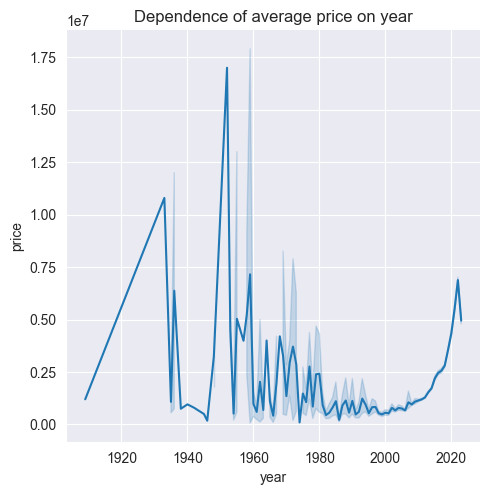

In [44]:
sns.relplot(data_train, x='year', y='price', kind='line')
plt.title('Dependence of average price on year')
plt.show()

C 2000-го года зависимость немного похожа на линейную, до этого выделим десятилетние периоды в качестве категориальных признаков.

In [45]:
data['year_lin'] = data.year * (data.year >= 2000)

In [46]:
import math

borders = [-math.inf] + list(range(1920, 2001, 5)) + [math.inf]
for i in range(1, len(borders)):
    data[f'year_range_{i}'] = ((borders[i - 1] <= data.year) & (data.year < borders[i])).astype(int)

#### 3.2 Пробег

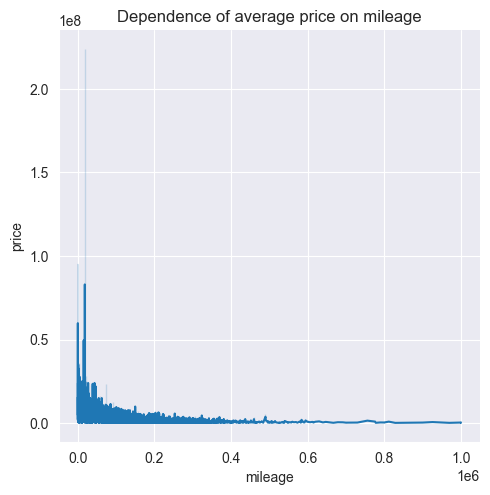

In [47]:
sns.relplot(data_train, x='mileage', y='price', kind='line')
plt.title('Dependence of average price on mileage')
plt.show()

Можем просто выделить две категории: пробег до 50000 или больше.

In [48]:
data['small_mileage'] = (data.mileage < 50000).astype(int)
data['large_mileage'] = 1 - data.small_mileage

#### 3.3 Мощность

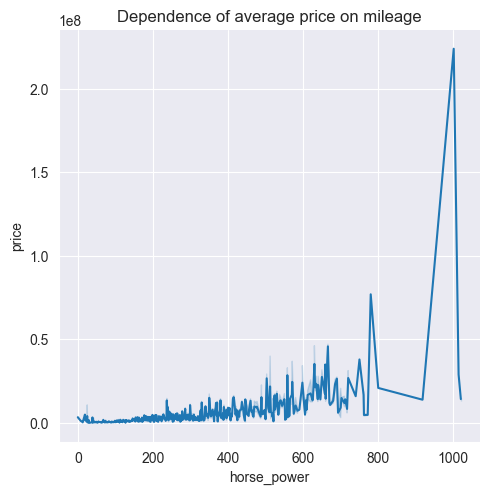

In [49]:
sns.relplot(data_train, x='horse_power', y='price', kind='line')
plt.title('Dependence of average price on mileage')
plt.show()

В целом тут можно оставить, как есть (т.к. авто с мощностью больше 800 л.с. очень мало)

Повторим эксперимент с новыми признаками.

In [51]:
data_train, data_test, y_train, y_test = train_test_split(data, data.price, random_state=42, test_size=0.2)

In [52]:
new_categorical = ['engine', 'body_type', 'fuel_type', 'transmission', 'seller_type', 'brand_name', 'model_name']
new_numeric = ['horse_power', 'year_lin']
new_passthrough = [col for col in data.columns if ((data[col] == 0) | (data[col] == 1)).all()]

new_column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), new_numeric),
    ('ohe', OneHotEncoder(handle_unknown='ignore'), new_categorical),
    ('passthrough', 'passthrough', new_passthrough)
])

new_column_transformer_with_tf_idf = ColumnTransformer([
    ('scaling', StandardScaler(), new_numeric),
    ('ohe', OneHotEncoder(handle_unknown='ignore'), new_categorical),
    ('tf-idf', TfidfVectorizer(), 'text'),
    ('passthrough', 'passthrough', new_passthrough)
])

In [53]:
cmp_table.loc['Ridge + new features'] = fit_and_evaluate(Ridge(), new_column_transformer)
cmp_table.loc['Ridge + new features + tf-idf'] = fit_and_evaluate(Ridge(), new_column_transformer_with_tf_idf)

In [55]:
cmp_table

,Train MSE,Test MSE,Train MAPE,Test MAPE
Ridge,3.586051e+12,3.665341e+12,0.773325,0.855170
Ridge + tf-idf,1.677033e+12,2.807453e+12,0.513088,0.758983
DecisionTree,1.044837e+11,1.698906e+12,0.007253,0.230721
DecisionTree + tf-idf,4.731898e+09,2.048746e+12,0.001915,0.247839
Ridge + new features,3.503887e+12,3.489303e+12,0.587054,0.632341
Ridge + new features + tf-idf,1.706145e+12,2.773767e+12,0.439271,0.633627


In [37]:
data.mileage.quantile(0.5)

75661.5

Новые признаки заметно улучшили качество. Результат всё ещё хуже, чем у дерева, но эти новые признаки нам ещё пригодятся.

### 4. Разбираемся с текстами

In [90]:
import torch
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
# model.cuda()  # uncomment it if you have a GPU

def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [61]:
from tqdm.notebook import tqdm

text_features_train = np.vstack([embed_bert_cls(text, model, tokenizer) for text in tqdm(data_train.description)])

  0%|          | 0/40702 [00:00<?, ?it/s]

In [92]:
np.save('text_features_train', text_features_train)

In [93]:
text_features_test = np.vstack([embed_bert_cls(text, model, tokenizer) for text in tqdm(data_test.description)])

  0%|          | 0/10176 [00:00<?, ?it/s]

In [94]:
np.save('text_features_test', text_features_test)

In [95]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [97]:
x_train = np.hstack([column_transformer.fit_transform(data_train).toarray(), text_features_train])
x_test = np.hstack([column_transformer.transform(data_test).toarray(), text_features_test])

In [98]:
x_train.shape, x_test.shape

((40702, 2140), (10176, 2140))

In [99]:
boosting = GradientBoostingRegressor()
boosting.fit(x_train, y_train)
boosting_pred = boosting.predict(x_test)

In [100]:
forest = RandomForestRegressor()
forest.fit(x_train, y_train)
forest_pred = forest.predict(x_test)

In [101]:
mean_absolute_percentage_error(y_test, boosting_pred)

0.37721509383069596

In [102]:
mean_absolute_percentage_error(y_test, forest_pred)

0.23110435349440583

In [104]:
simple_boosting = GradientBoostingRegressor()
simple_boosting.fit(column_transformer.transform(data_train), y_train)
simple_boosting_pred = simple_boosting.predict(column_transformer.transform(data_test))

In [105]:
mean_absolute_percentage_error(y_test, simple_boosting_pred)

0.3719973812823832

In [107]:
simple_forest = RandomForestRegressor()
simple_forest.fit(column_transformer.transform(data_train), y_train)
simple_forest_pred = simple_forest.predict(column_transformer.transform(data_test))

In [108]:
mean_absolute_percentage_error(y_test, simple_forest_pred)

0.18102931689327006